#Jitter Test for Overfitting


In this notebook I describe some intuition about possible testing of predicion models for overfitting.

Notebook contain description of the idea, its application to classification and regression models with continuous features, comparison with cross validation and performance considerations.

###Overfitting in Classification Models

Assume that we have models $ M_0 $ (overfitted) and $ M_1 $ (non-overfitted) that trained on data $ [X, y ] $. 

For overfitted model boundary between predicted categories is bigger than for non-overfitted model. So if we jitter $X$ and look at the accuracy of prediction $ M_i(jitter(X, \sigma)) \rightarrow y $ it will decrease faster with growing $\sigma$ for overfitted model, since more points will cross boundary between predictions.

Therefore accuracy decrease should look like this:

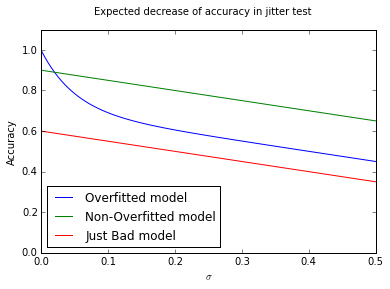

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


x = np.linspace(0, 0.5, 100)

plt.plot( x, 0.7 - 0.5*x + 0.3*np.exp(-x*20), label = "Overfitted model")
plt.plot( x, 0.9 - 0.5*x, label = "Non-Overfitted model")
plt.plot( x, 0.6 - 0.5*x, label = "Just Bad model")

axes = plt.gca()
axes.set_ylim([0, 1.1])

plt.legend(loc=3)
plt.suptitle("Expected decrease of accuracy in jitter test")

axes.set_xlabel('$\sigma$')
axes.set_ylabel('Accuracy')

plt.show()

Probably area under the plot of $ Accuracy(M(jitter(X,\sigma))) $ can be better metric to analyze models than accuracy itself 
since it also can incorporate information about overfitting.

Below you can see examples of different prediction models from "Supervised learning superstitions cheat sheet" 
notebook https://github.com/rcompton/ml_cheat_sheet with added jitter test.

And plot of accuracy in jitter test for these models.

In [2]:
# Jitter test code

from sklearn.metrics import accuracy_score

def jitter(X, scale):
    #out = X.copy()
    if scale > 0:        
        return X + np.random.normal(0, scale, X.shape)
    return X

def jitter_test(classifier, X, y, metric_FUNC = accuracy_score, sigmas = np.linspace(0, 0.5, 30), averaging_N = 5):
    out = []
    
    for s in sigmas:
        averageAccuracy = 0.0
        for x in range(averaging_N):
            averageAccuracy += metric_FUNC( y, classifier.predict(jitter(X, s)))

        out.append( averageAccuracy/averaging_N)

    return (out, sigmas, np.trapz(out, sigmas))

allJT = {}

In [3]:
"""
Build some datasets that I'll demo the models on
"""

import sklearn
import sklearn.datasets
#sklearn two moons generator makes lots of these...
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Xs = []
ys = []

#low noise, plenty of samples, should be easy
X0, y0 = sklearn.datasets.make_moons(n_samples=1000, noise=.05)
Xs.append(X0)
ys.append(y0)

#more noise, plenty of samples
X1, y1 = sklearn.datasets.make_moons(n_samples=1000, noise=.3)
Xs.append(X1)
ys.append(y1)

#less noise, few samples
X2, y2 = sklearn.datasets.make_moons(n_samples=200, noise=.05)
Xs.append(X2)
ys.append(y2)

#more noise, less samples, should be hard
X3, y3 = sklearn.datasets.make_moons(n_samples=200, noise=.3)
Xs.append(X3)
ys.append(y3)

In [4]:
def plotter(model, X, Y, ax, npts=10000):
    """
    Simple way to get a visualization of the decision boundary 
    by applying the model to randomly-chosen points
    could alternately use sklearn's "decision_function"
    at some point it made sense to bring pandas into this
    """
    xs = []
    ys = []
    cs = []
    for _ in range(npts):
        x0spr = max(X[:,0])-min(X[:,0])
        x1spr = max(X[:,1])-min(X[:,1])
        x = np.random.rand()*x0spr + min(X[:,0])
        y = np.random.rand()*x1spr + min(X[:,1])
        xs.append(x)
        ys.append(y)
        cs.append(model.predict([x,y]))
    ax.scatter(xs,ys,c=list(map(lambda x:'lightgrey' if x==0 else 'black', cs)), alpha=.35)
    ax.hold(True)
    ax.scatter(X[:,0],X[:,1],
                 c=list(map(lambda x:'r' if x else 'lime',Y)), 
                 linewidth=0,s=25,alpha=1)
    ax.set_xlim([min(X[:,0]), max(X[:,0])])
    ax.set_ylim([min(X[:,1]), max(X[:,1])])
    return

####LogisticRegression

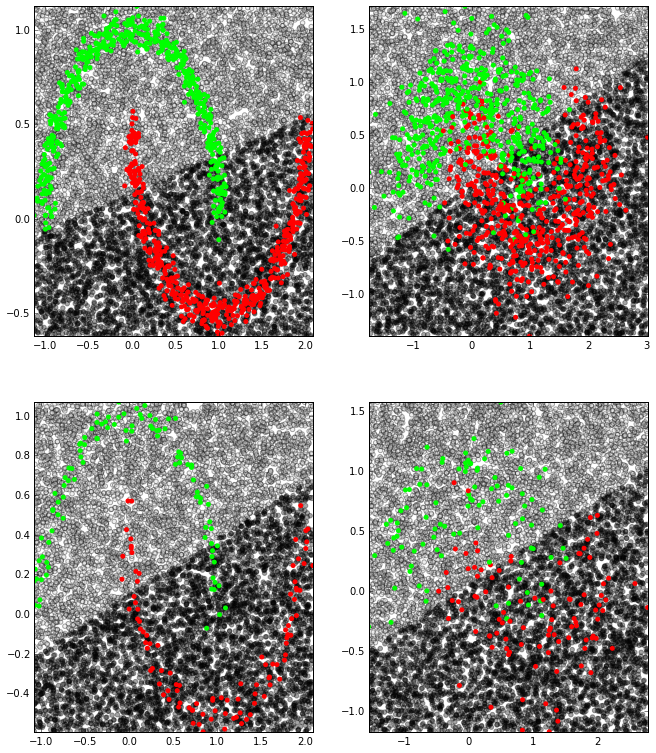

In [5]:
import sklearn.linear_model
classifier = sklearn.linear_model.LogisticRegression()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))

allJT[str(classifier)] = list()
#allJT[str(classifier)].append (jitter_test(classifier, X, y))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    allJT[str(classifier)].append (jitter_test(classifier, X, y))
    i += 1
plt.show()

####DecisionTreeClassifier

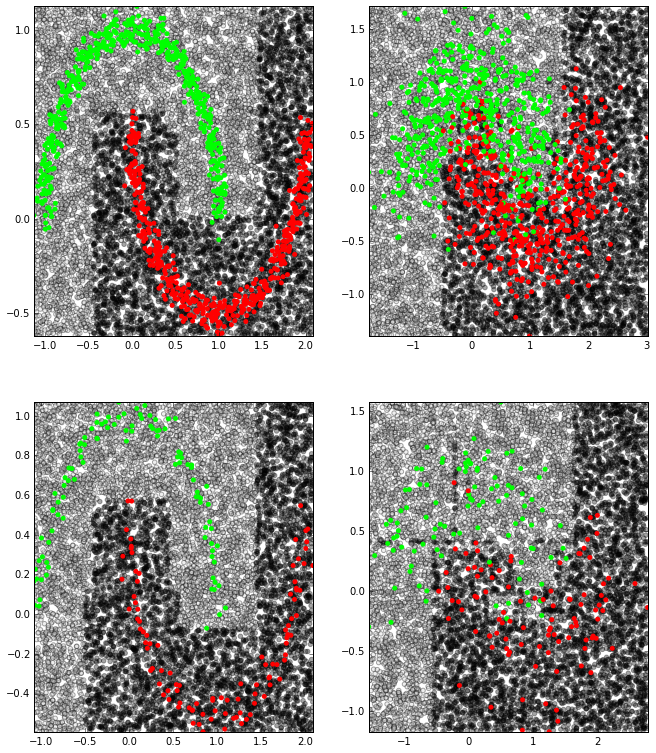

In [6]:
import sklearn.tree
classifier = sklearn.tree.DecisionTreeClassifier()

allJT[str(classifier)] = list()
#allJT[str(classifier)].append (jitter_test(classifier, X, y))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    allJT[str(classifier)].append (jitter_test(classifier, X, y))
    i += 1
plt.show()

####Support Vector Machines

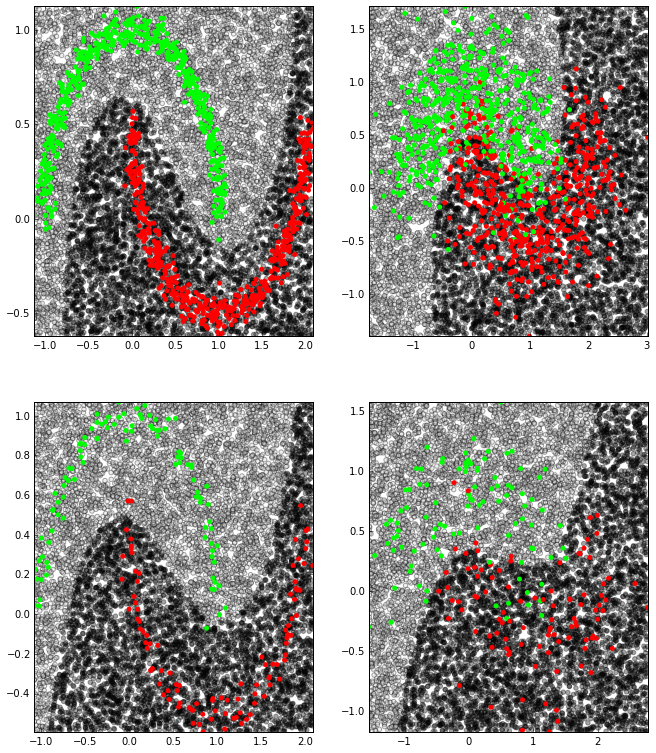

In [7]:
import sklearn.svm
classifier = sklearn.svm.SVC()

allJT[str(classifier)] = list()
#allJT[str(classifier)].append (jitter_test(classifier, X, y))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    allJT[str(classifier)].append (jitter_test(classifier, X, y))
    i += 1
plt.show()

####Accuracy in jitter test

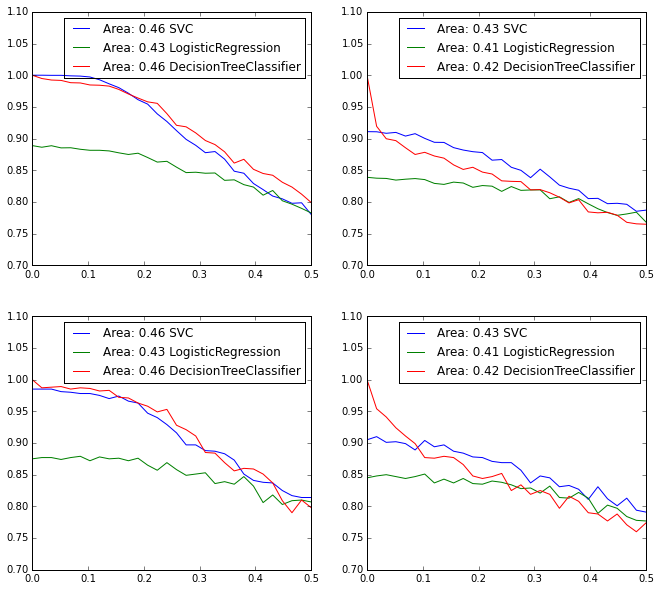

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,10))



handlers =[]
for c_name in allJT:
    for i in range(4): 

        ax=axes[i//2,i%2]
        
        ax.set_xlim([0, 0.5])
        ax.set_ylim([0.7, 1.1])

        accuracy, sigmas, area = allJT[c_name][i]
        ax.plot( sigmas, accuracy, label = "Area: {:.2} ".format(area) + c_name.split("(")[0])
        ax.legend()
    
plt.show()

####Conclusion

DecisionTreeClassifier demonstrate overfitting behavior on high-noise data (rightmost pictures). That can be seen from plot itself and computed area under accuracy curve.

###Overfitting in Regression Models

Same approach can be applies to regression.

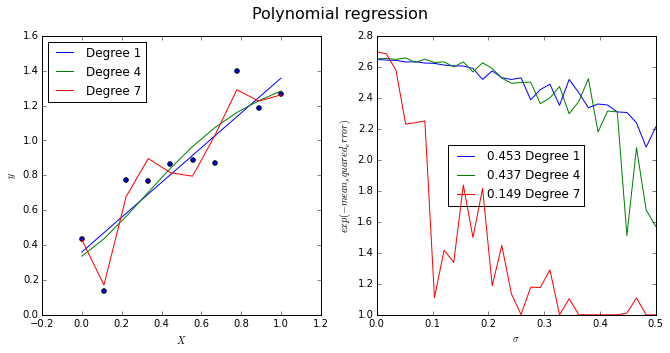

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Generate sample data for regression
np.random.seed(2)
N_points = 10
X = np.linspace(0, 1, N_points)
y = np.random.rand(N_points) + X
X = X[:, np.newaxis]

allJT = {}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

ax=axes[0]
ax.scatter(X, y)

#for i in [1, 5, 9]:
for i in [1, 4, 7]:
    model = Pipeline([('poly', PolynomialFeatures(degree=i)),
                   ('linear', LinearRegression())])

    model = model.fit(X, y)
    
    allJT[i] = jitter_test(model, X, y, lambda x,y: np.exp(-mean_squared_error(x,y)))
    
    ax.plot(X, model.predict(X), label="Degree {}".format(i))

plt.suptitle("Polynomial regression", fontsize=16)
ax.legend(loc=2)
ax.set_xlabel('$X$')
ax.set_ylabel('$y$')



ax=axes[1]
#ax.set_xlim([0, .4])

for i in allJT:
    accuracy, sigmas, area = allJT[i]
    ax.plot( sigmas, np.exp(accuracy), label = "{:.3} ".format(area) + "Degree {}".format(i) )

ax.legend(loc=10)
ax.set_xlabel('$\sigma$')
ax.set_ylabel('$exp(-mean_squared_error)$')

plt.show()





##Comparison with Cross Validation

Let's try to find best model using cross validation and compare results with JTO

In [14]:
from sklearn import cross_validation
#more noise, plenty of samples
#X1, y1
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X1, y1, test_size=0.4, random_state=120) #10

In [15]:


def CV_test( X_train, y_train, depth, averaging, random_state_ = 1):
    out =[]
    for i in depth:
        classifier = sklearn.tree.DecisionTreeClassifier(max_depth=i, random_state = random_state_)
        scores = cross_validation.cross_val_score(classifier, X_train, y_train, cv=averaging)
        out.append(scores.mean())
        
    return out

def JOT_test(X_train, y_train, depth, averaging, random_state_ = 1):
    out =[]
    

    for i in depth:
        classifier = sklearn.tree.DecisionTreeClassifier(max_depth=i, random_state = random_state_)
        classifier.fit(X_train, y_train)
        jitter_errors, sigmas, score = jitter_test(classifier, X_train, y_train, averaging_N=averaging)
        
        #plt.plot(sigmas, jitter_errors, alpha=float(i+1)/(max(depth)+1), color="blue")
        out.append( score)

    #plt.show()
    return out

test_range = range(1,30)
averaging = 50

cv_accuracy = CV_test(X_train, y_train, test_range, averaging)
jot_score = JOT_test(X_train, y_train, test_range, averaging)

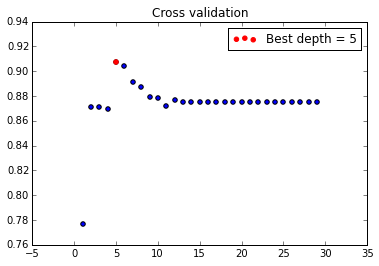

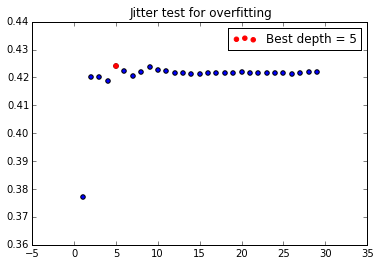

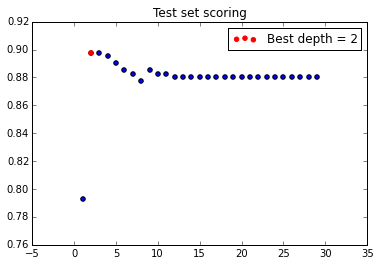

Scores on test set
CV   = 0.89
JTO  = 0.89
Test = 0.8975


In [16]:
def plot_scoring(test_range, score, title):
    plt.scatter(test_range, score)
    plt.title(title)
    
    best_id = np.argmax(score)
    plt.scatter(test_range[best_id], score[best_id], color="red", label = "Best depth = {}".format(test_range[best_id]))    
    plt.legend()
    plt.show()
    
    return best_id

score_cv_id = plot_scoring(test_range, cv_accuracy, "Cross validation")

score_JTO_id = plot_scoring(test_range, jot_score, "Jitter test for overfitting")

# Compute scoring for test set
test_score = []
for i in test_range:
    test_score.append(sklearn.tree.DecisionTreeClassifier(max_depth=i, random_state=1).fit(X_train, y_train).score(X_test, y_test))

score_test = plot_scoring(test_range, test_score, "Test set scoring")

print "Scores on test set"
print "CV   = {}\nJTO  = {}\nTest = {}".format(test_score[score_cv_id], test_score[score_JTO_id], test_score[score_test])

Let's see how averaged results for JOT and CV looks like.

In [17]:
repeat_N = 10
test_best_score = 0.
jot_best_score = 0.
cv_best_score = 0.

for i in range(repeat_N):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X1, y1, test_size=0.4)
    
    cv_accuracy = CV_test(X_train, y_train, test_range, averaging, None)    
    
    jot_score = JOT_test(X_train, y_train, test_range, averaging, None)    
    
    test_score = []
    for i in test_range:
        test_score.append(sklearn.tree.DecisionTreeClassifier(max_depth=i).fit(X_train, y_train).score(X_test, y_test))
        
    test_best_score += test_score[np.argmax(test_score)]
    jot_best_score += test_score[np.argmax(jot_score)]
    cv_best_score += test_score[np.argmax(cv_accuracy)]

print "Average score:"
print "Test = {}\nJOT  = {}\nCV   ={}".format(test_best_score/repeat_N, jot_best_score/repeat_N, cv_best_score/repeat_N)
    

Average score:
Test = 0.893
JOT  = 0.884
CV   =0.88125


###Conlusion
JOT shows small improvemnet over CV in average.

##Performance testing


In [19]:
import timeit

repeat_N = 10
cv_time = timeit.Timer('CV_test(X_train, y_train, test_range, averaging)', "from __main__ import CV_test, X_train, y_train, test_range, averaging").timeit(repeat_N)
jot_time = timeit.Timer('JOT_test(X_train, y_train, test_range, averaging)', "from __main__ import JOT_test, X_train, y_train, test_range, averaging").timeit(repeat_N)

print "Timing"
print "CV  = {} sec.\nJOT = {} sec.".format(cv_time, jot_time)

Timing
CV  = 19.8625406034 sec.
JOT = 110.018068498 sec.


This implementation of jitter test is much slower than cross validation. But iwould expect that it will be faster when model training is very slow. Since in CV case we have to train model on every data subset and then make prediction and find out a score. While for JOT we train model only once and than make multiple predictions.